TODO:
- [ ] Grad flow for different layers (Conv, RNN, etc.)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST

from boring_utils.utils import *

%matplotlib inline 
init_graph()
device = get_device()
set_seed(42, strict=True)

In [2]:
DATASET_PATH = "../data"

# Implement Activation Functions

In [3]:
act_fn_by_name = {}

## Sigmoid and Tanh

In [4]:
class Sigmoid(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid
    '''
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

act_fn_by_name['sigmoid'] = Sigmoid


class StableSigmoid(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid
    '''
    def forward(self, x):
        return 4 / (1 + torch.exp(-x)) - 2

act_fn_by_name['stablesigmoid'] = StableSigmoid


class Softmax(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Softmax.html#torch.nn.Softmax
    '''
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        exp_x = torch.exp(x)
        sum_exp_x = torch.sum(exp_x, dim=self.dim, keepdim=True)
        return exp_x / sum_exp_x
        # return F.softmax(x, self.dim, _stacklevel=5)

# act_fn_by_name['softmax'] = Softmax  # let's skip this rn :(


class Tanh(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Tanh.html#torch.nn.Tanh
    '''
    def forward(self, x):
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

act_fn_by_name['tanh'] = Tanh


class Tanhshrink(nn.Module):
    '''
    https://pytorch.org/docs/stable/generated/torch.nn.Tanhshrink.html
    '''
    def forward(self, x):
        return x - (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

act_fn_by_name['tanhshrink'] = Tanhshrink


class Softplus(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Softplus.html#torch.nn.Softplus
    '''
    def __init__(self, beta=1, threshold=20):
        super().__init__()
        self.beta = beta
        self.threshold = threshold

    def forward(self, x):
        softplus =  1/self.beta * torch.log(1 + torch.exp(self.beta * x))
        return torch.where(x > self.threshold, x, softplus)

act_fn_by_name['softplus'] = Softplus


class Mish(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Mish.html#torch.nn.Mish
    '''
    def forward(self, x):
        soft_plus = torch.nn.functional.softplus(x)
        tanh_x = torch.tanh(soft_plus)
        return x * tanh_x

act_fn_by_name['mish'] = Mish

## ReLU and Swish

In [5]:
class ReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.ReLU.html#torch.nn.ReLU
    '''
    def forward(self, x):
        # return torch.max(0, x)
        return x * (x > 0).float()

act_fn_by_name['relu'] = ReLU


class LeakyReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU
    '''
    def __init__(self, negative_slope=0.1):
        super().__init__()
        self.neg_slop = negative_slope
        
    def forward(self, x):
        return torch.where(x > 0, x, self.neg_slop * x)

act_fn_by_name['leakyrelu'] = LeakyReLU


class PReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.PReLU.html#torch.nn.PReLU
    '''
    def __init__(self, num_parameters=1, init=0.25):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(num_parameters).fill_(init))

    def forward(self, x):
        return torch.where(x > 0, x, self.weight * x)

# act_fn_by_name['prelu'] = PReLU  # also skip this :(


class ELU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.ELU.html#torch.nn.ELU
    '''
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.alpha * (torch.exp(x) - 1))

act_fn_by_name['elu'] = ELU
    

class SiLU(nn.Module):
    '''
    https://pytorch.org/docs/stable/generated/torch.nn.SiLU.html
    '''
    def forward(self, x):
        return x * torch.sigmoid(x)

act_fn_by_name['silu'] = SiLU


class GELU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.GELU.html#torch.nn.GELU
    '''
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                np.sqrt(2 / torch.pi) * (x + 0.044715 * torch.pow(x, 3))
                )
            )

act_fn_by_name['gelu'] = GELU

In [6]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.
    
    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor. 
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"


def vis_act_fn(act_fn, ax, x, lims=(-1.5, 2.5)):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="act Fn")
    ax.plot(x, y_grads, linewidth=2, label="grad")
    ax.set_title(act_fn)
    ax.legend()
    ax.legend(fontsize=12)
    ax.set_ylim(*lims)


def vis_act_fn_softmax(act_fn, ax, x, lims=(-1.5, 2.5)):
    # Create a 2D input tensor by stacking x with itself
    x_2d = torch.stack([x, x], dim=1)
    
    # Run activation function
    y = act_fn(x_2d)
    
    # Push x and y back to cpu for plotting
    x, y = x.cpu().numpy(), y.cpu().numpy()
    
    # Plotting
    ax.plot(x, y[:, 0], linewidth=2, label="Softmax (class 0)")
    ax.plot(x, y[:, 1], linewidth=2, label="Softmax (class 1)")
    ax.set_title(act_fn)
    ax.legend()
    ax.set_ylim(*lims)


In [7]:
# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]

cprint(act_fns)

<module> -> act_fns:
[Sigmoid(),
 StableSigmoid(),
 Tanh(),
 Tanhshrink(),
 Softplus(),
 Mish(),
 ReLU(),
 LeakyReLU(),
 ELU(),
 SiLU(),
 GELU()]


## Vis: Full

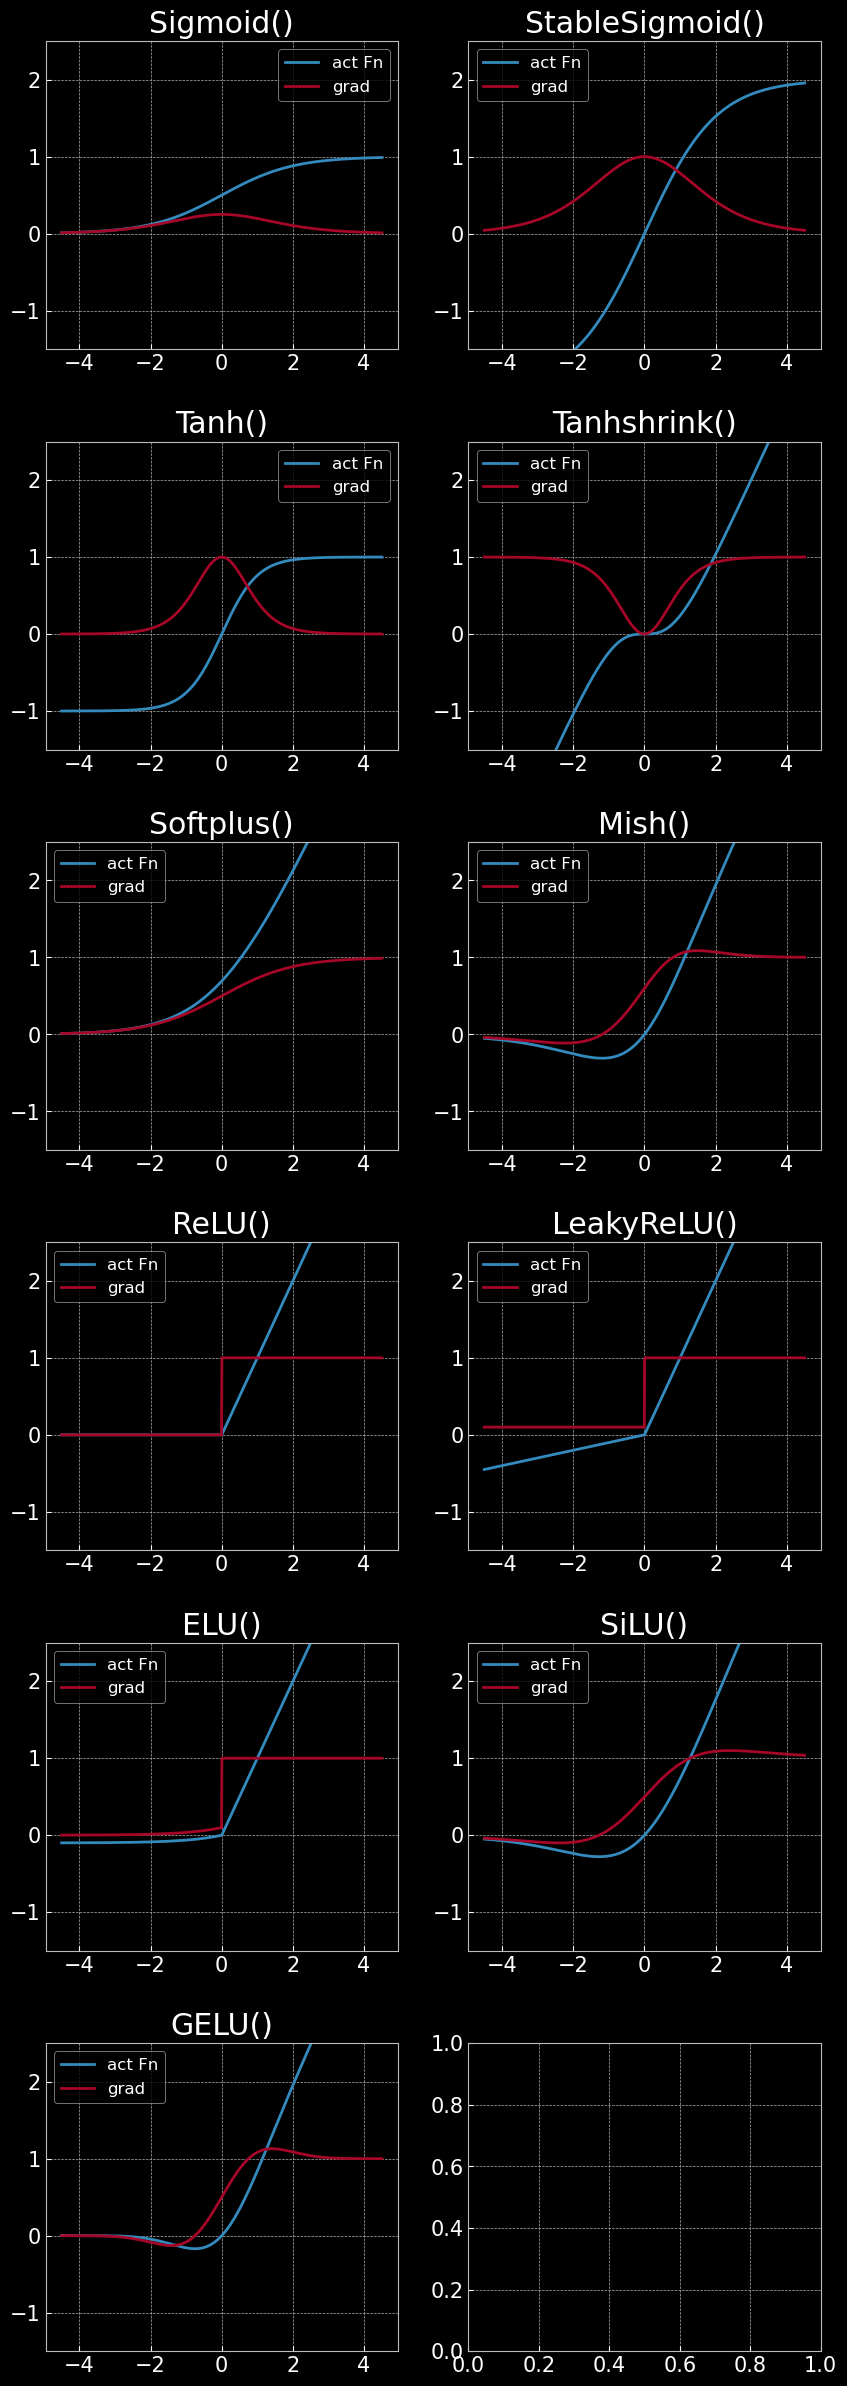

In [8]:
# NOTE: the Softmax function expects the input tensor to have at least 2 dimensions, where the second dimension represents the classes or logits
x = torch.linspace(-4.5, 4.5, 1000)

# Plotting
rows = int(np.ceil(len(act_fns) / 2.0))
fig, ax = plt.subplots(rows, 2, figsize=(10, rows*5))

for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)

fig.subplots_adjust(hspace=0.3)
plt.show()

## Vis: (-1, 1)

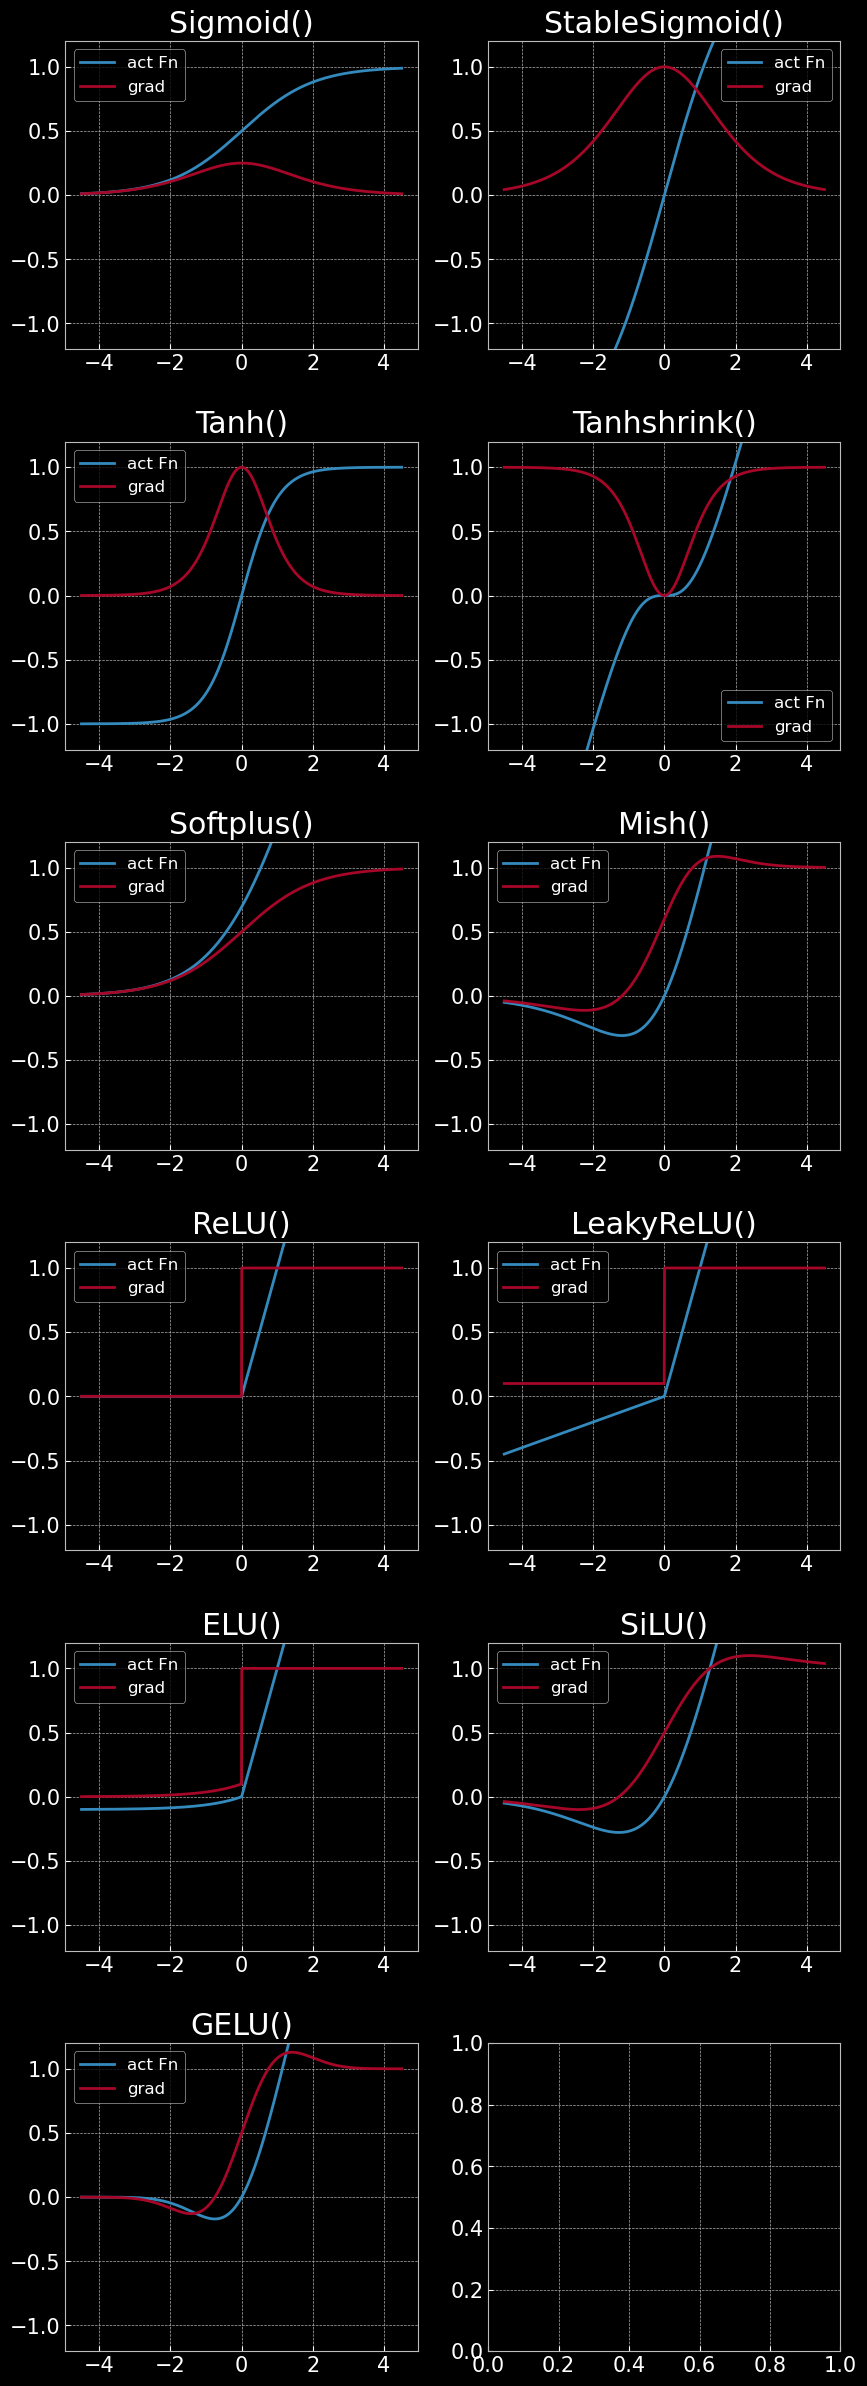

In [9]:
rows = int(np.ceil(len(act_fns) / 2.0))
fig, ax = plt.subplots(rows, 2, figsize=(10, rows*5))

for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x, lims=(-1.2, 1.2))

fig.subplots_adjust(hspace=0.3)
plt.show()

In [10]:
Softmax(dim=None).forward(torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]]))

tensor([[0.0450, 0.1224, 0.3326],
        [0.0450, 0.1224, 0.3326]])

In [11]:
cprint(Softmax)

<module> -> Softmax:
<class '__main__.Softmax'>


# Analysing the Effect of Activation Functions: NN

In [12]:
class BaseNN(nn.Module):
    def __init__(self, act_fn, input_size=784, hidden_sizes=[512, 256, 256, 128], num_classes=10):
        super().__init__()
        
        self.act_fn = act_fn
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [
                nn.Linear(layer_sizes[layer_index-1], 
                          layer_sizes[layer_index]),
                self.act_fn
                ]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # reshape img to flat tensor
        x = x.view(-1, self.input_size)
        x = self.layers(x)
        return x
        

In [13]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(
    root=DATASET_PATH, 
    train=True, 
    download=True, 
    transform=transform
)

test_set = FashionMNIST(
    root=DATASET_PATH, 
    train=False, 
    download=True, 
    transform=transform
)


In [14]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader = DataLoader(
    train_set, batch_size=1024, shuffle=True, drop_last=False)

val_loader = DataLoader(
    val_set, batch_size=1024, shuffle=True, drop_last=False)

test_loader = DataLoader(
    test_set, batch_size=1024, shuffle=True, drop_last=False)

# Preview FashionMNIST

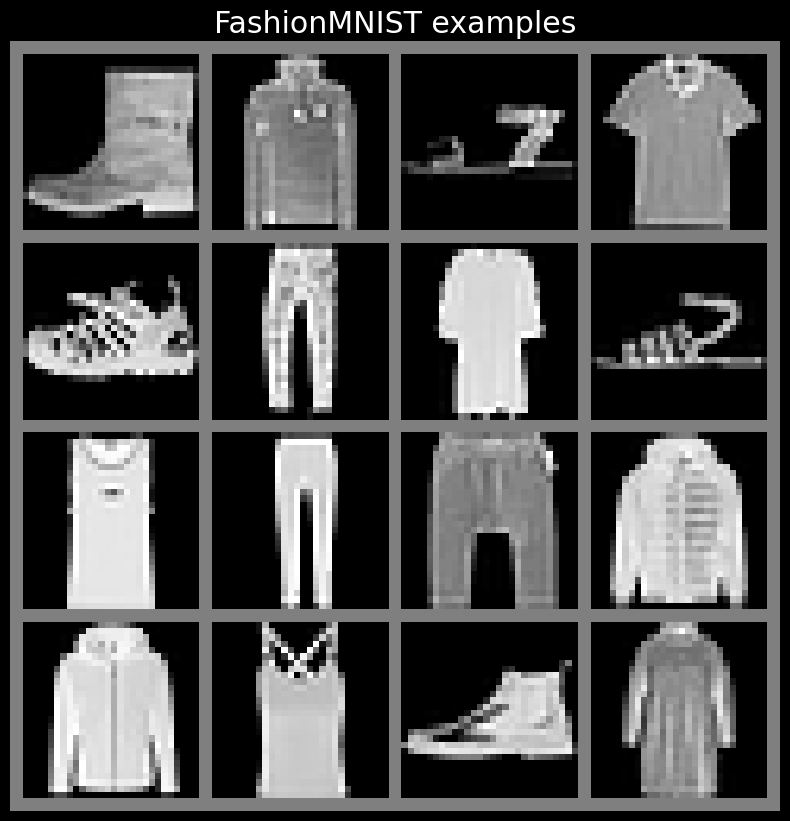

In [15]:
exmp_imgs = [train_set[i][0] for i in range(16)]

# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(
                torch.stack(exmp_imgs, dim=0), 
                nrow=4, 
                normalize=True, 
                pad_value=0.5
            )
img_grid = img_grid.permute(1, 2, 0)

plt.figure()
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [16]:
# img shape: torch.Size([1, 28, 28]), stack at dim 0
# img_grid shape: torch.Size([122, 122, 3]) = (C, H, W) to (H, W, C)
cprint(train_set[0][0].shape, img_grid.shape)

<module> -> train_set[0][0].shape:
torch.Size([1, 28, 28])
<module> -> img_grid.shape:
torch.Size([122, 122, 3])


# Visualizing the Gradient Flow after Initialization

One important aspect of activation functions is how they propagate gradients through the network, especially for the very deep NN.

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient of 1/4, and finding a suitable learning rate across all layers is not possible in this setup.

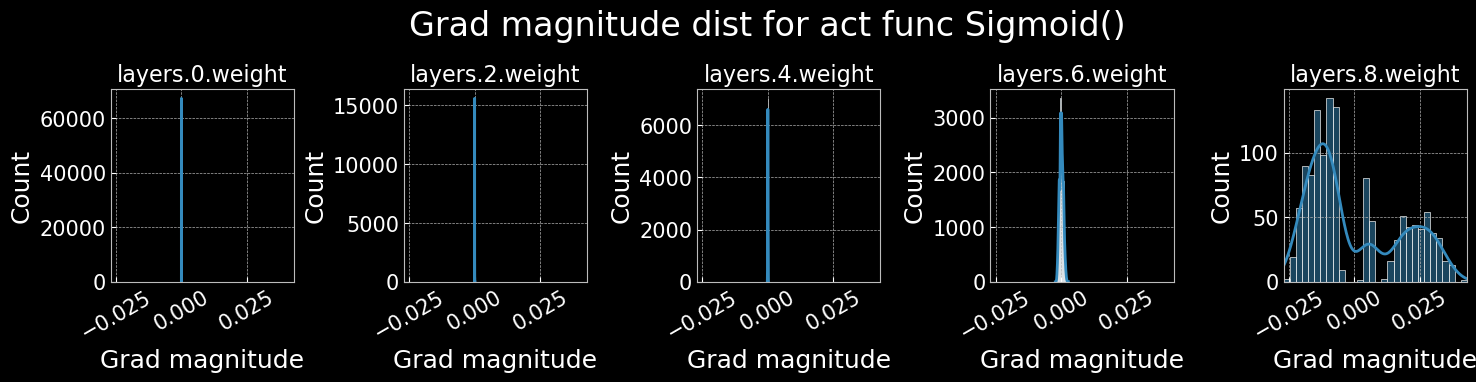

visualize_gradients_weight -> x_min:
-0.027015235
visualize_gradients_weight -> x_max:
0.04299868


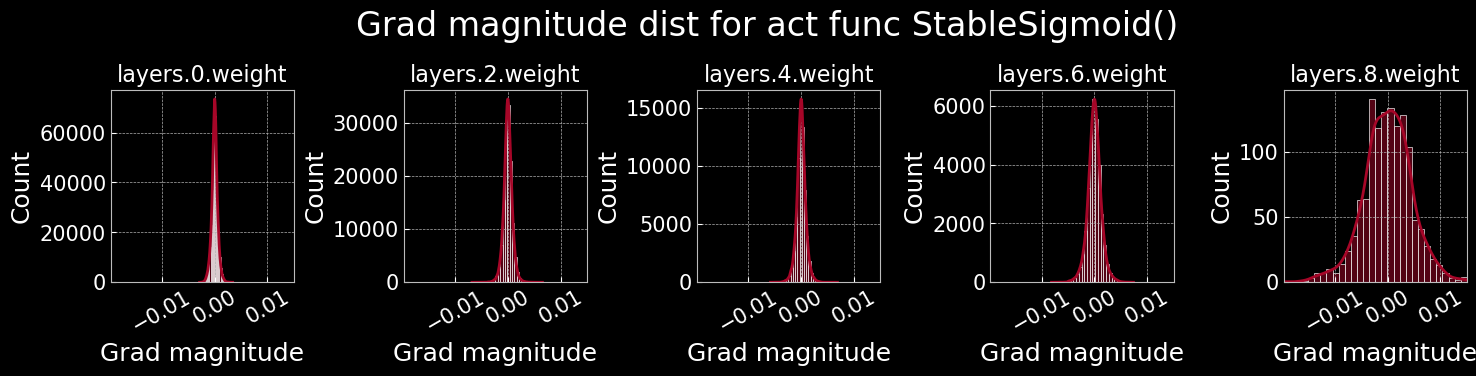

visualize_gradients_weight -> x_min:
-0.019703344
visualize_gradients_weight -> x_max:
0.01501433


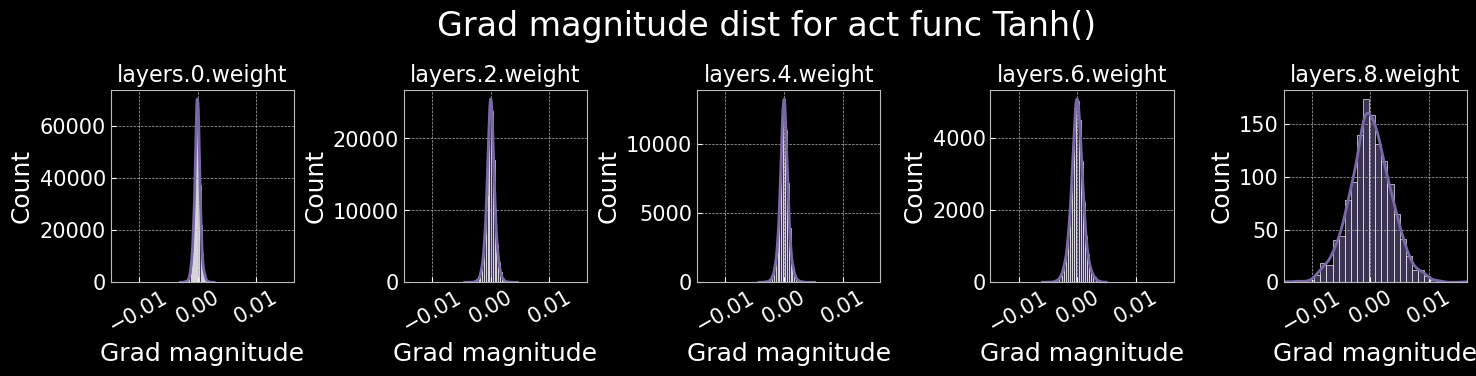

visualize_gradients_weight -> x_min:
-0.014815748
visualize_gradients_weight -> x_max:
0.016448986


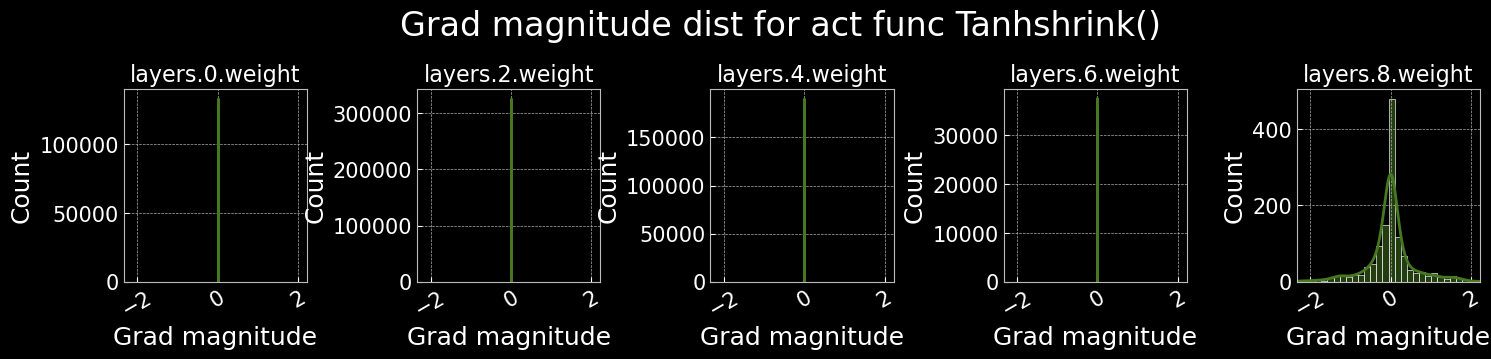

visualize_gradients_weight -> x_min:
-2.914985e-06
visualize_gradients_weight -> x_max:
2.7844035e-06


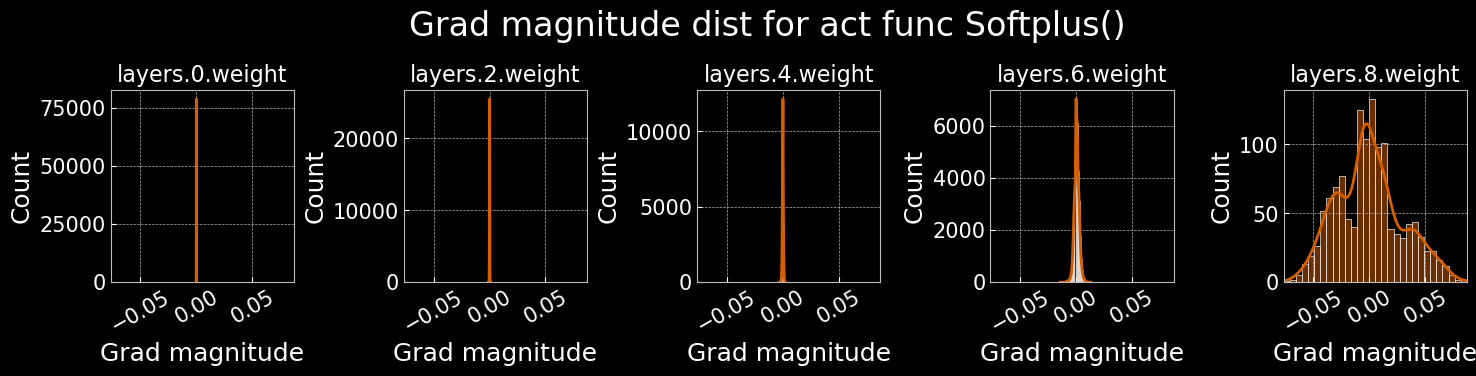

visualize_gradients_weight -> x_min:
-0.07664106
visualize_gradients_weight -> x_max:
0.08730776


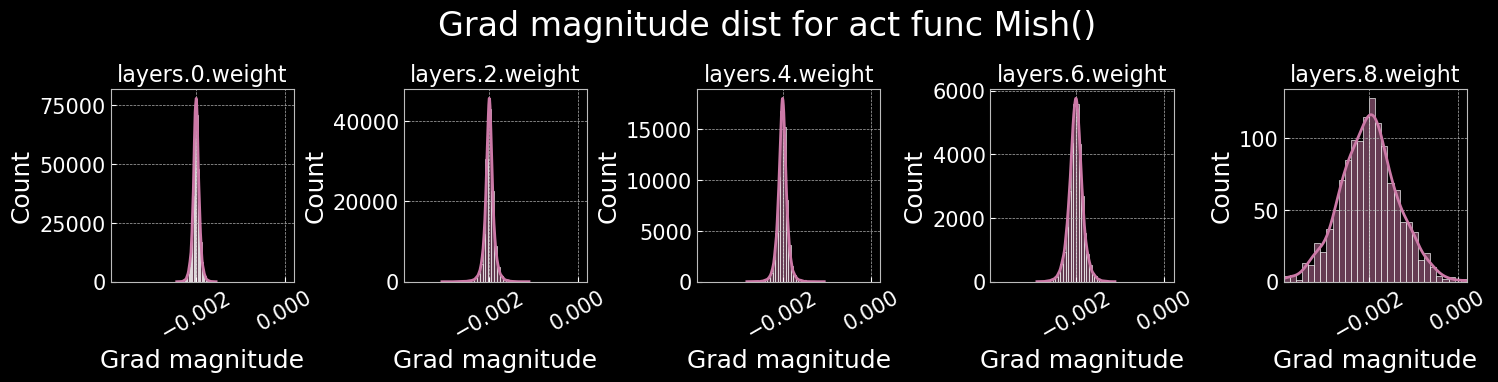

visualize_gradients_weight -> x_min:
-0.0024089722
visualize_gradients_weight -> x_max:
0.0027609984


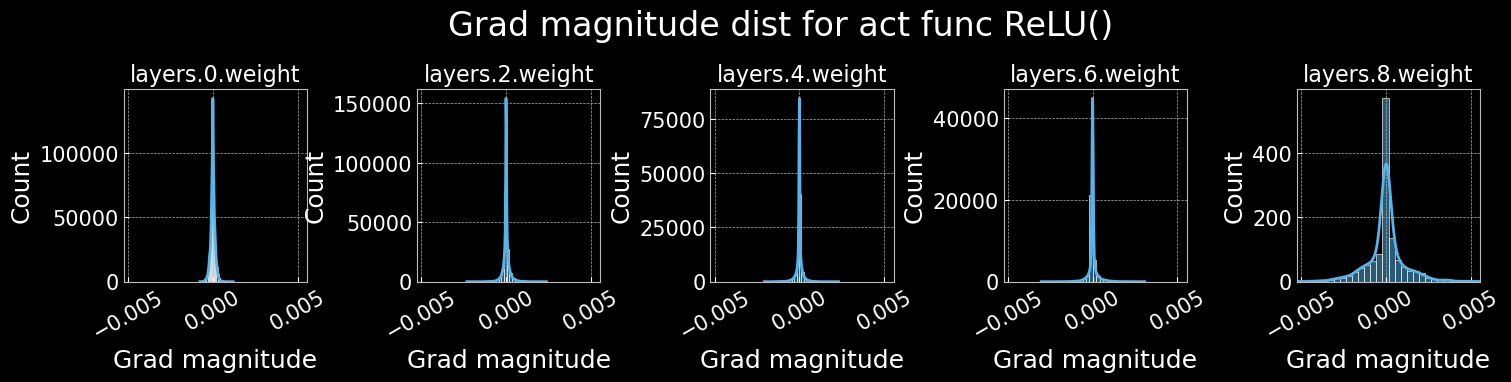

visualize_gradients_weight -> x_min:
-0.005254022
visualize_gradients_weight -> x_max:
0.005568942


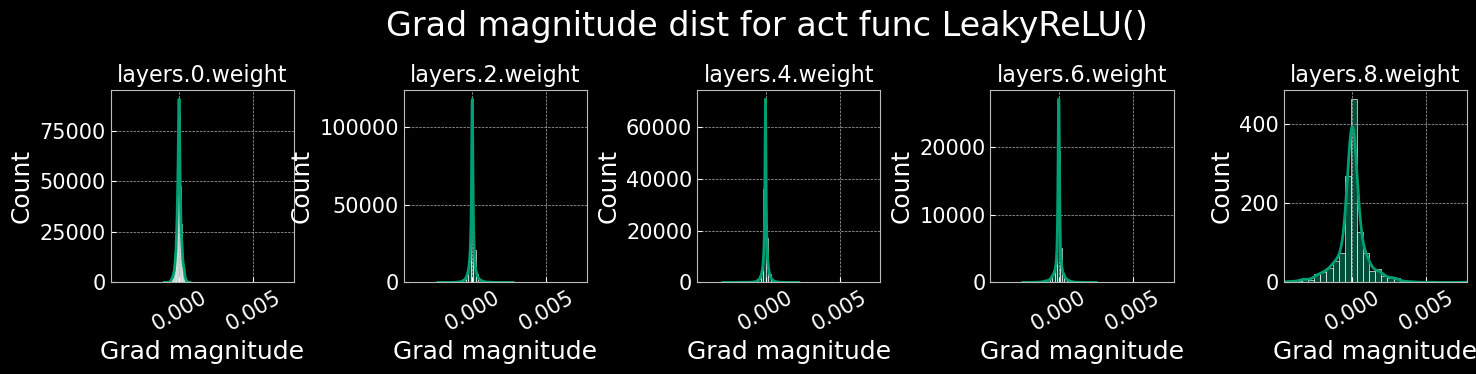

visualize_gradients_weight -> x_min:
-0.0046177194
visualize_gradients_weight -> x_max:
0.007763161


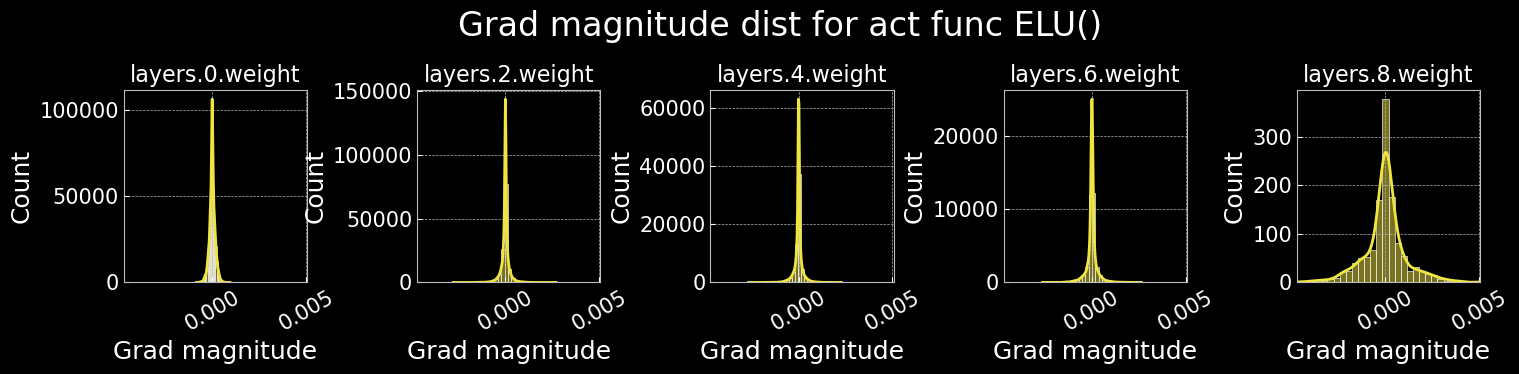

visualize_gradients_weight -> x_min:
-0.004702191
visualize_gradients_weight -> x_max:
0.005062951


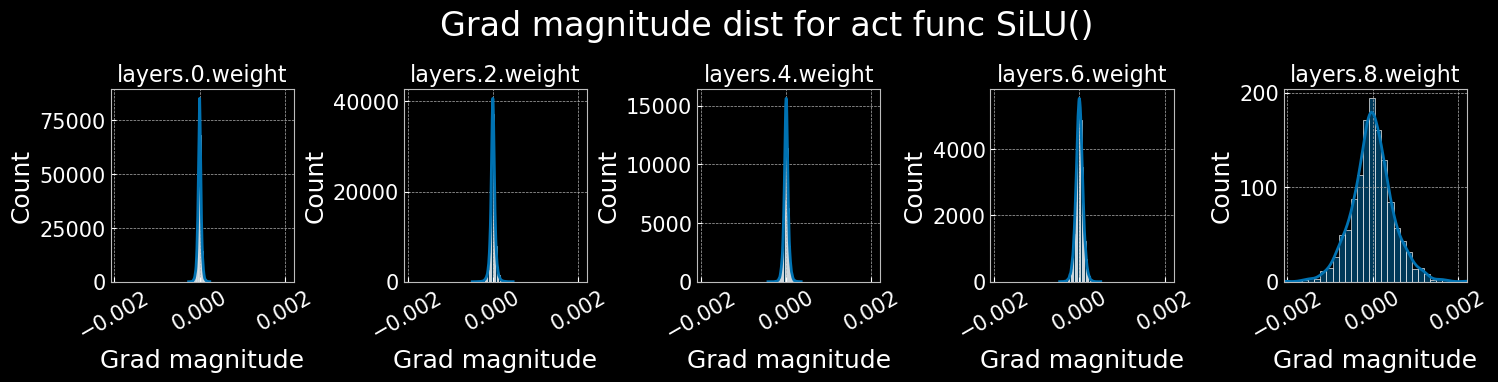

visualize_gradients_weight -> x_min:
-0.0020870597
visualize_gradients_weight -> x_max:
0.002212961


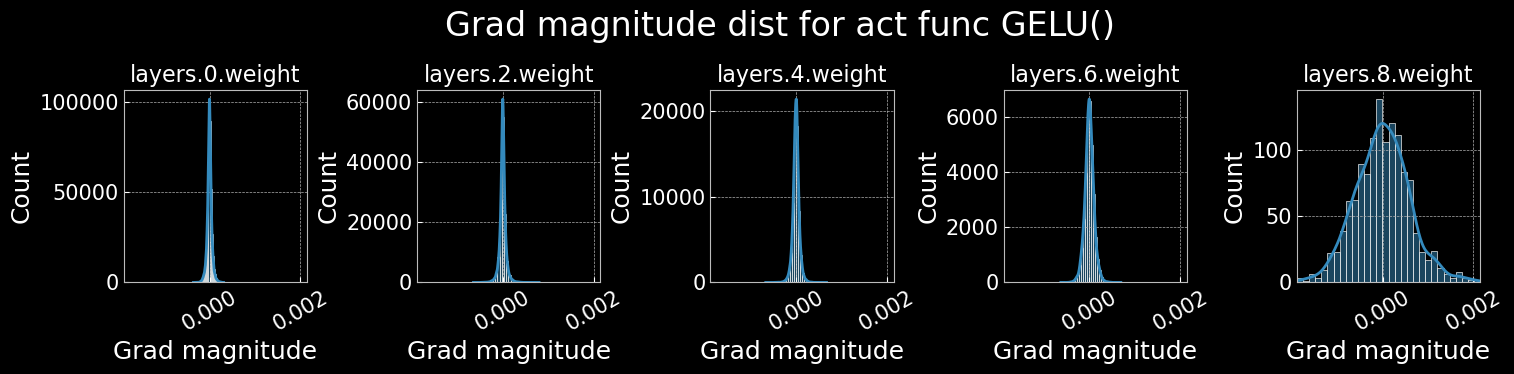

visualize_gradients_weight -> x_min:
-0.001886517
visualize_gradients_weight -> x_max:
0.0021508406


In [17]:
import warnings; warnings.filterwarnings('ignore')
from boring_functions import visualize_gradients_weight


# Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNN(act_fn=act_fn).to(device)
    visualize_gradients_weight(
        net_actfn, 
        train_set,
        device,
        norm_x_axis=True,
        norm_y_axis=False,
        color=f"C{i}")
    # break